### TorchVision Object Detection Finetuning Tutorial

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

### 데이터 준비
https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip를 url주소창에 입력해 다운로드

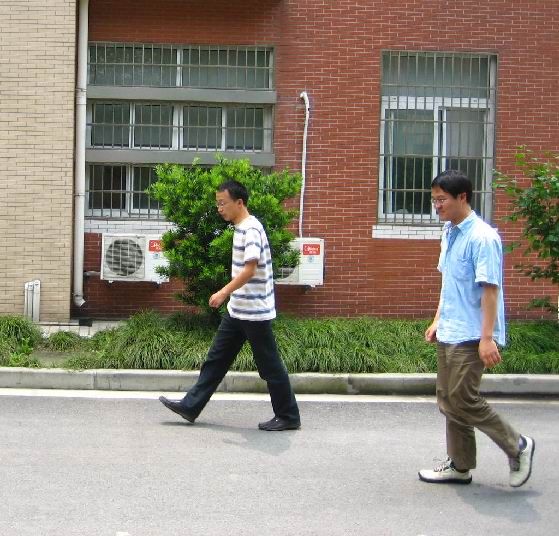

In [16]:
from torchvision.io import read_image
from PIL import Image
img_path ='./data/PennFudanPed/PNGImages/FudanPed00001.png'
image=Image.open(img_path)
image

In [17]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
       # 이미지와 마스크 로드
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
      # 색상 인코딩된 마스크를 바이너리 마스크로 분할
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

      # 각 마스크에 대한 경계 상자 좌표 계산
        boxes = masks_to_boxes(masks)

       # 클래스 레이블 생성 (여기서는 하나의 클래스만 사용)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

         # 샘플과 타겟을 torchvision의 tv_tensors로 래핑
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### 모델

In [23]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# torchvision 라이브러리를 사용하여 COCO 데이터셋에서 사전 학습된 Faster R-CNN 모델을 로드한 후, 특정 사용자 정의 클래스 수에 맞게 모델의 분류기(클래시파이어)를 교체하는 방법을 보여줍니다.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT") #weights="DEFAULT"는 COCO 데이터셋에서 사전 학습된 가중치를 로드합니다.

num_classes = 2 # 2개 클래스(배경 + 객체)를 설정했습니다.

in_features = model.roi_heads.box_predictor.cls_score.in_features   #기존의 분류기에서 입력 특징 수를 가져옵니다.

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # 사전 학습된 헤드를 사용자 정의 클래스 수를 갖는 새 헤드로 교체

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\user/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


코드의 목적 <br />
모델 수정: 사전 학습된 모델의 분류기(헤드)를 사용자 정의 클래스 수에 맞게 수정합니다. COCO 데이터셋에서 학습된 모델은 다양한 클래스(80개 클래스)를 예측하도록 설계되어 있으며, 이를 특정 데이터셋의 클래스 수에 맞게 조정할 때 이 방법을 사용합니다. <br />
사용자 정의 데이터셋 학습: 사용자 정의 데이터셋이 특정 클래스 수를 가지는 경우, 분류기를 교체하여 새 데이터셋에 맞게 모델을 조정합니다.

In [ ]:
model

In [24]:

#이미지에 대한 변환을 정의하는 함수를 구현한 예제입니다. 이 함수는 학습(training) 및 추론(inference) 모드에 따라 이미지에 다른 변환을 적용합니다.

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))   
    transforms.append(T.ToPureTensor())                  #이 변환은 ToTensor()의 기능과 유사하지만, ToPureTensor()는 불필요한 채널을 제거합니다.
    return T.Compose(transforms)                         #여러 변환을 순차적으로 적용합니다.

In [25]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn               #collate_fn 함수는 각 배치에 포함될 샘플들을 어떻게 결합할지 결정합니다
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1082, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0826, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0166, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0018, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


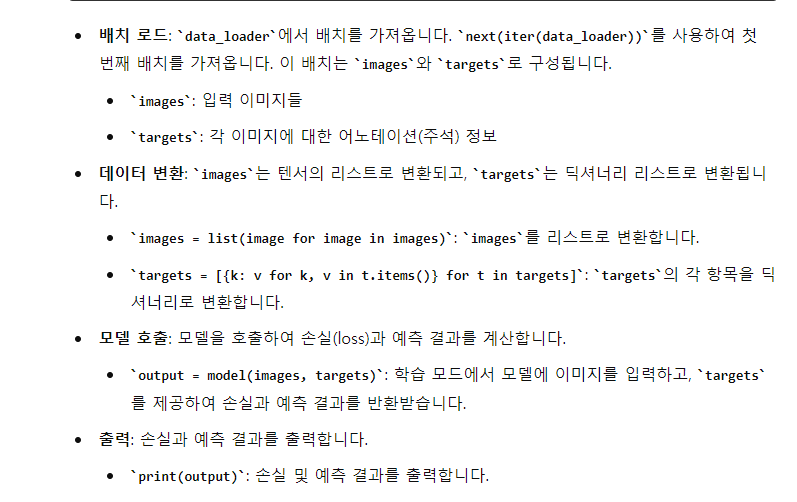
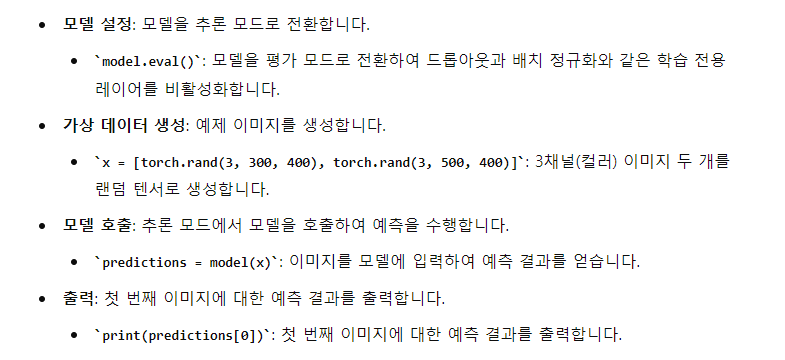

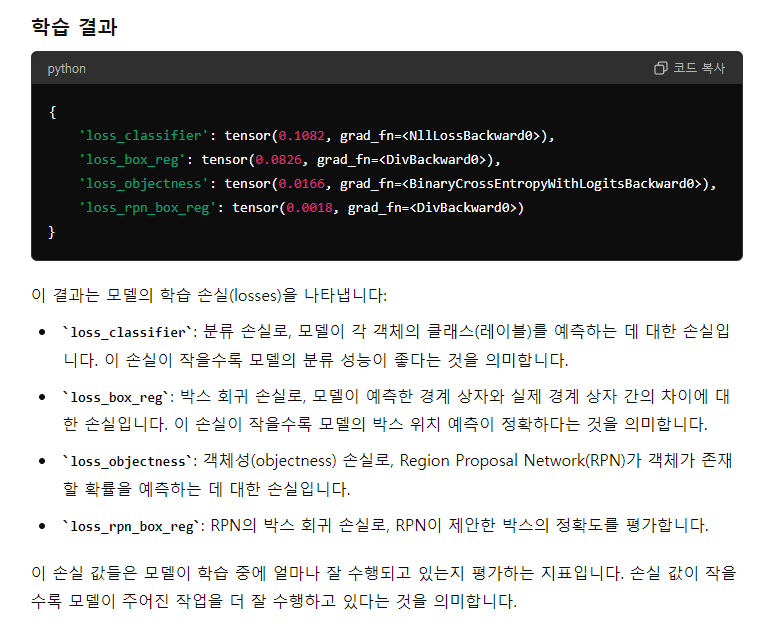
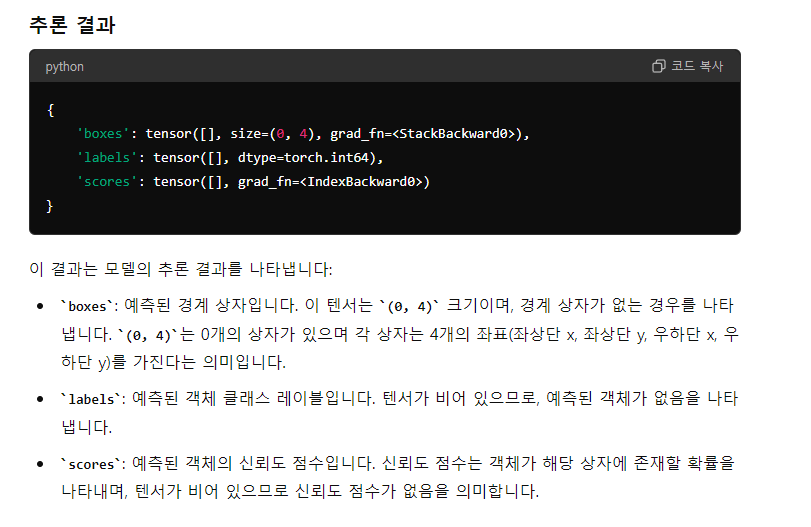

### 최종 코드

In [30]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import pycocotools

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\user/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100.0%
C:\deeplearning_h\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:11:20  lr: 0.000090  loss: 4.6031 (4.6031)  loss_classifier: 0.6426 (0.6426)  loss_box_reg: 0.1677 (0.1677)  loss_mask: 3.7507 (3.7507)  loss_objectness: 0.0386 (0.0386)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 11.3427  data: 0.0349


In [ ]:
#pip install pycocotools